In [56]:
#!pip install -q numpy==1.26.4

In [ ]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sweetviz as sv
import torch
import torch.nn as nn
import optuna
import lightgbm as lgb

from typing import Optional, List, Callable, Union, Tuple
from sqlalchemy.engine import Engine
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score as sklearn_f1_score, ConfusionMatrixDisplay, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from phik import phik_matrix
from sqlalchemy import create_engine
from abc import ABC, abstractmethod

In [58]:
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [59]:
RANDOM_STATE = 0
TEST_SIZE = 0.2
torch.manual_seed(RANDOM_STATE)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## Шаг 1. Загрузка таблиц sql

In [60]:
def connect_to_db() -> Optional[Engine]:
    try:
        db_config = {
            'user': 'praktikum_student',
            'pwd': 'Sdf4$2;d-d30pp', 
            'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
            'port': 6432,
            'db': 'data-science-vehicle-db'
        } 
        connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
            db_config['user'],
            db_config['pwd'],
            db_config['host'],
            db_config['port'],
            db_config['db']
        )
        return create_engine(connection_string)
    
    except Exception as e:
        print(f'Error: {e}')
        return None


In [61]:
def get_any_data(query: str) -> Optional[pd.DataFrame]:
    try:
        engine = connect_to_db()
        return pd.read_sql_query(query, con=engine)
    
    except Exception as e:
        print(f'Error: {e}')
        return None

In [62]:
def get_data() -> Optional[pd.DataFrame]:
    try:
        engine = connect_to_db()

        query = '''
            SELECT 
                v.party_number, v.vehicle_type, v.vehicle_transmission, v.vehicle_age,
                c.collision_date, c.case_id
            FROM vehicles v
            JOIN collisions c ON v.case_id = c.case_id
            JOIN parties p ON v.case_id = p.case_id
            WHERE
                c.collision_date BETWEEN '2012-01-01' AND '2012-12-31'
                AND c.collision_damage != 'scratch'
                AND p.party_type = 'car';

        '''
        data = pd.read_sql_query(query, con=engine)
        data.collision_date = pd.to_datetime(data.collision_date)
        data['month'] = data.collision_date.dt.month
        data.vehicle_age = data.vehicle_age.fillna(-1).astype('int')
        return data
    except Exception as e:
        print(f'Error: {e}')
        return None

In [63]:
def line_chart(data: pd.DataFrame, 
               index: Union[str, List[str]], 
               values: Union[str, List[str]], 
               aggfunc: Union[str, Callable], 
               **kwargs) -> None:
    data.pivot_table(
        index=index,
        values=values,
        aggfunc=aggfunc).plot(     
            style='o-',
            figsize=(15, 6),
            markerfacecolor='blue',
            markeredgecolor='black',
            markersize=8,
            linewidth=2,
            fontsize=14,
            **kwargs
        )
    
    plt.legend(loc='upper left')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [64]:
def bar_chart(data, column, **kwargs) -> None:
    data[column].value_counts().plot(
        kind='bar',
        figsize=(11,7),
        color='#BA55D3',
        **kwargs
    )
    plt.legend()
    plt.show()

In [65]:
data = get_any_data(query = 
    '''
        SELECT
            c.*,
            p.party_number, p.at_fault, p.insurance_premium, p.party_sobriety, p.party_drug_physical, p.cellphone_in_use,
            v.vehicle_type, v.vehicle_transmission, v.vehicle_age
        FROM
            collisions c
        INNER JOIN
            parties p ON c.case_id = p.case_id
        INNER JOIN
            vehicles v ON c.case_id = v.case_id
        WHERE
            c.collision_date BETWEEN '2012-01-01' AND '2012-12-31'
            AND c.collision_damage != 'scratch'
            AND p.party_type = 'car';
    '''
                    )
analyze_data = get_data()

## Шаг 2. Первичное исследование таблиц

In [66]:
data.head()

,case_id,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time,party_number,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use,vehicle_type,vehicle_transmission,vehicle_age
0,5449062,0708,contra costa,21.0,east,0.0,clear,None,small damage,2,vehicle code violation,dui,rear end,other motor vehicle,dry,normal,dark with street lights,functioning,2012-01-15,02:00:00,1,1,31.0,"had been drinking, under influence",None,0.0,sedan,manual,10.0
1,5454105,3015,orange,50.0,north,0.0,clear,highway,small damage,2,vehicle code violation,other hazardous violation,hit object,other object,dry,normal,daylight,none,2012-01-31,14:02:00,1,1,61.0,had not been drinking,None,0.0,sedan,manual,9.0
2,5454105,3015,orange,50.0,north,0.0,clear,highway,small damage,2,vehicle code violation,other hazardous violation,hit object,other object,dry,normal,daylight,none,2012-01-31,14:02:00,1,1,61.0,had not been drinking,None,0.0,sedan,manual,5.0
3,5455510,0112,alameda,15.0,south,0.0,cloudy,ramp,small damage,2,vehicle code violation,automobile right of way,broadside,other motor vehicle,dry,normal,dark with street lights,functioning,2012-01-02,20:09:00,1,1,43.0,had not been drinking,None,0.0,sedan,auto,9.0
4,5455957,3801,san francisco,0.0,None,1.0,clear,None,middle damage,2,vehicle code violation,automobile right of way,broadside,other motor vehicle,dry,normal,daylight,functioning,2012-01-28,08:42:00,1,1,45.0,had not been drinking,None,0.0,sedan,manual,NaN


## Шаг 3. Статистический анализ факторов ДТП

### Задание 1.

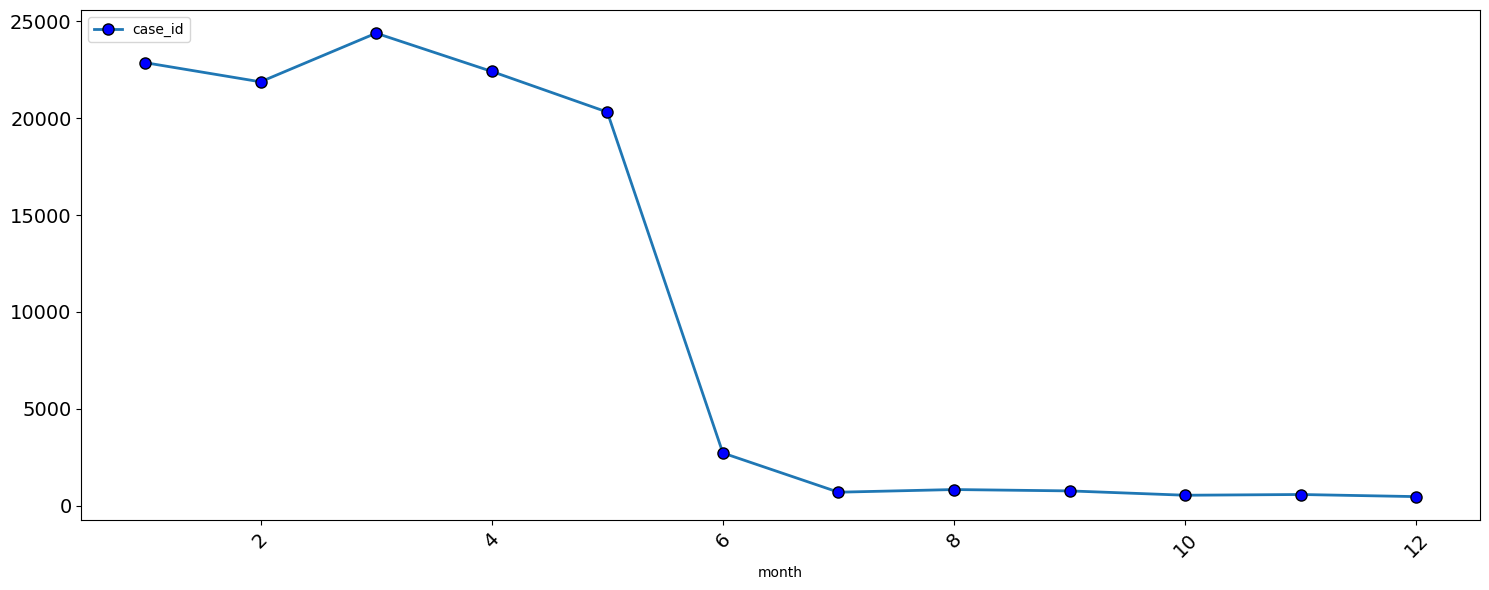

In [67]:
line_chart(analyze_data, 'month', 'case_id', 'count')

### Задание 2

Задачи для коллег 

    Аналитические задачи для коллег:

        Проанализировать использование телефона за рулем и погодные условия
        Цель: определить, при каких условиях чаще происходят аварии

        Исследовать связь времени суток с тяжестью повреждений
        Цель: выявить периоды с наиболее серьёзными последствиями

        Определить, как возраст водителя влияет на вероятность ДТП
        Цель: найти возрастные группы с повышенным риском

        Изучить распределение ДТП по типам дорожного покрытия
        Цель: выявить опасные типы дорог

        Проанализировать связь между скоростным режимом на участке и количеством ДТП
        Цель: определить, как скорость влияет на аварийность

        Оценить влияние освещения дороги на частоту ДТП в ночное время
        Цель: проверить, снижает ли освещение риски

Решение задачи 1 - 'Проанализировать влияние погодных условий на частоту ДТП'

#### Решение первой задачи

In [68]:
query_task1 = '''
    SELECT 
        c.weather_1,
        p.cellphone_in_use
    FROM collisions c
    JOIN parties p ON c.case_id = p.case_id
    WHERE 
        c.collision_date BETWEEN '2012-01-01' AND '2012-12-31'
        AND c.collision_damage != 'scratch'
        AND p.party_type = 'car'
        AND p.at_fault = 1
        AND c.weather_1 IS NOT NULL
        AND p.cellphone_in_use IS NOT NULL
        AND p.cellphone_in_use = 1;
'''
task1 = get_any_data(query_task1)

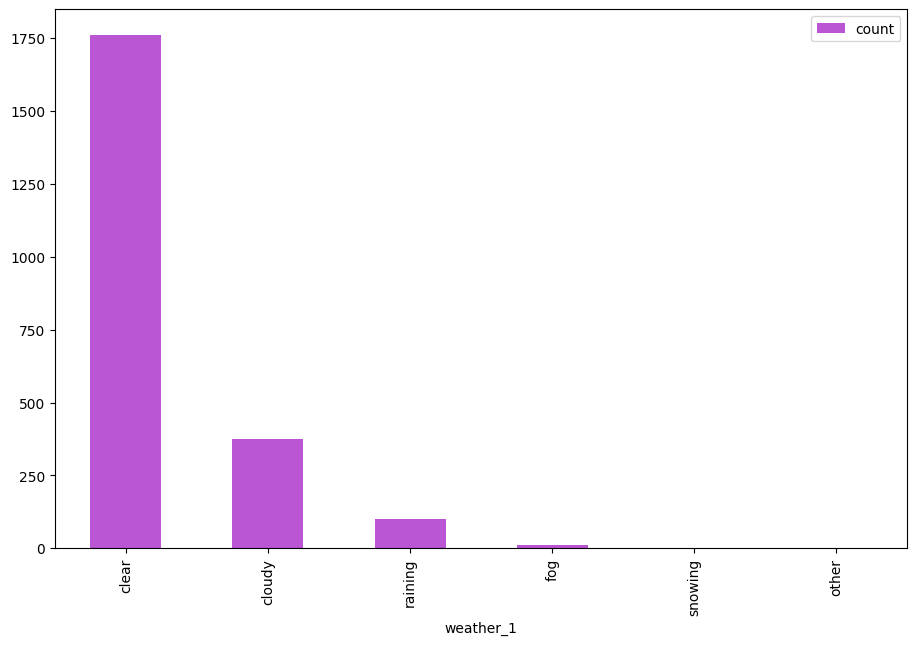

In [69]:
bar_chart(task1, 'weather_1')

#### Решение второй задачи

In [70]:
query_task2 = '''
    SELECT 
        c.weather_1,
        p.cellphone_in_use
    FROM collisions c
    JOIN parties p ON c.case_id = p.case_id
    WHERE 
        c.collision_date BETWEEN '2012-01-01' AND '2012-12-31'
        AND c.collision_damage != 'scratch'
        AND p.party_type = 'car'
        AND p.at_fault = 1
        AND c.weather_1 IS NOT NULL
        AND p.cellphone_in_use IS NOT NULL
        AND p.cellphone_in_use = 1;
'''
task2 = get_any_data(query_task2)

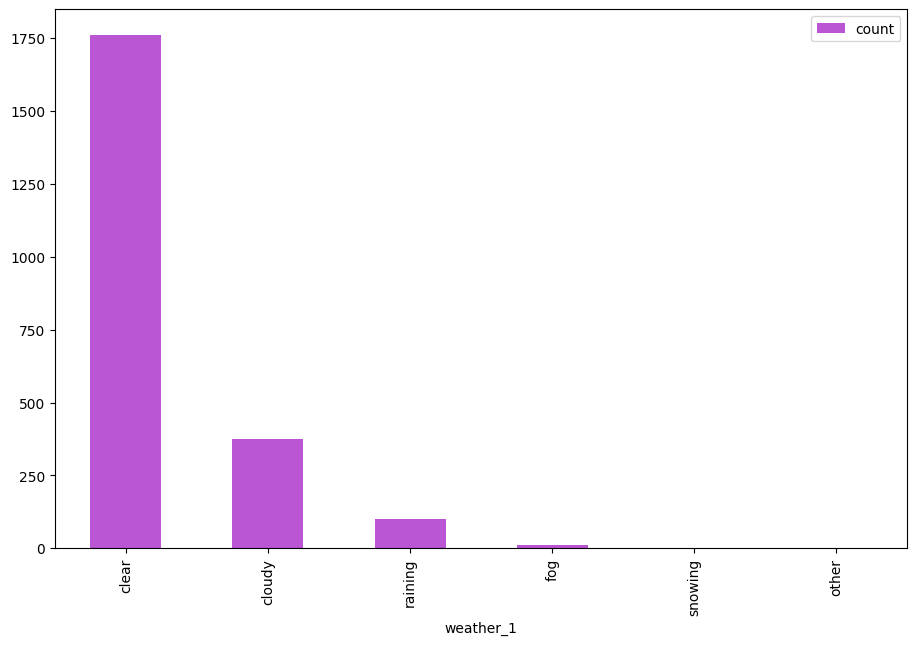

In [71]:
bar_chart(task1, 'weather_1')

## Предобработка

In [72]:
data = data.drop_duplicates()
data.case_id = data.case_id.astype('int')
data = data[data['distance'] < 4000.0]
data.direction = data.direction.fillna('unknown').astype('category')
data.intersection = data.intersection.apply(lambda x: 'Y' if x == 1. else 
                                                      'N' if x == 0 else x).fillna('unknown').astype('category')
data.weather_1 = data.weather_1.fillna('unknown').astype('category')
data.location_type = data.location_type.fillna('unknown').astype('category')
data.collision_damage = data.collision_damage.astype('category')
data.party_count = data.party_count.apply(lambda x: '5+' if x > 4 else x).apply(
    lambda x: 'one' if x == 1 else
              'two' if x == 2 else
              'three' if x == 3 else
              'four' if x == 4 else
              'five_plus' if str(x) == '5+' else x).astype('category')
data.primary_collision_factor = data.primary_collision_factor.fillna('unknown').astype('category')
data.pcf_violation_category = data.pcf_violation_category.fillna('unknown').astype('category')
data.type_of_collision = data.type_of_collision.fillna('other').astype('category')
data.motor_vehicle_involved_with = data.motor_vehicle_involved_with.fillna('unknown').astype('category')
data.road_surface = data.road_surface.fillna('unknown').astype('category')
data.road_condition_1 = data.road_condition_1.fillna('other').astype('category')
data.lighting = data.lighting.fillna('unknown').astype('category')
data.control_device = data.control_device.fillna('unknown').astype('category')
data.collision_date = pd.to_datetime(data.collision_date)
data['collision_month'] = data.collision_date.dt.month
data['collision_day'] = data.collision_date.dt.day
data.collision_time = pd.to_datetime(data.collision_time, format='%H:%M:%S')
data['collision_hour'] = data.collision_time.dt.hour
data.party_number = data.party_number.apply(lambda x: '5+' if x > 4 else x).apply(
    lambda x: 'one' if x == 1 else
              'two' if x == 2 else
              'three' if x == 3 else
              'four' if x == 4 else
              'five_plus' if str(x) == '5+' else x).astype('category')
data.at_fault = data.at_fault.astype('category')
data.party_sobriety = data.party_sobriety.fillna('unknown').astype('category')
data.party_drug_physical = data.party_drug_physical.fillna('unknown').astype('category')
data.cellphone_in_use = data.cellphone_in_use.fillna('3.0').apply(
    lambda x: 'no' if x == 0 else
              'yes' if x == 1 else
              'unknown' if x == 3 else x).astype('category')
data.vehicle_type = data.vehicle_type.astype('category')
data.vehicle_transmission = data.vehicle_transmission.fillna('unknown').astype('category')
data = data[data['vehicle_age'] < 161.0]
data['insurance_premium'] = data['insurance_premium'].fillna(-1)
data['collision_hour'] = data['collision_hour'].interpolate()
data.at_fault = data.at_fault.astype('int')


In [73]:
# report = sv.analyze(data)
# report.show_notebook()

## Шаг 4. Создание моделей для оценки водительского риска

### Подготовка данных для моделей

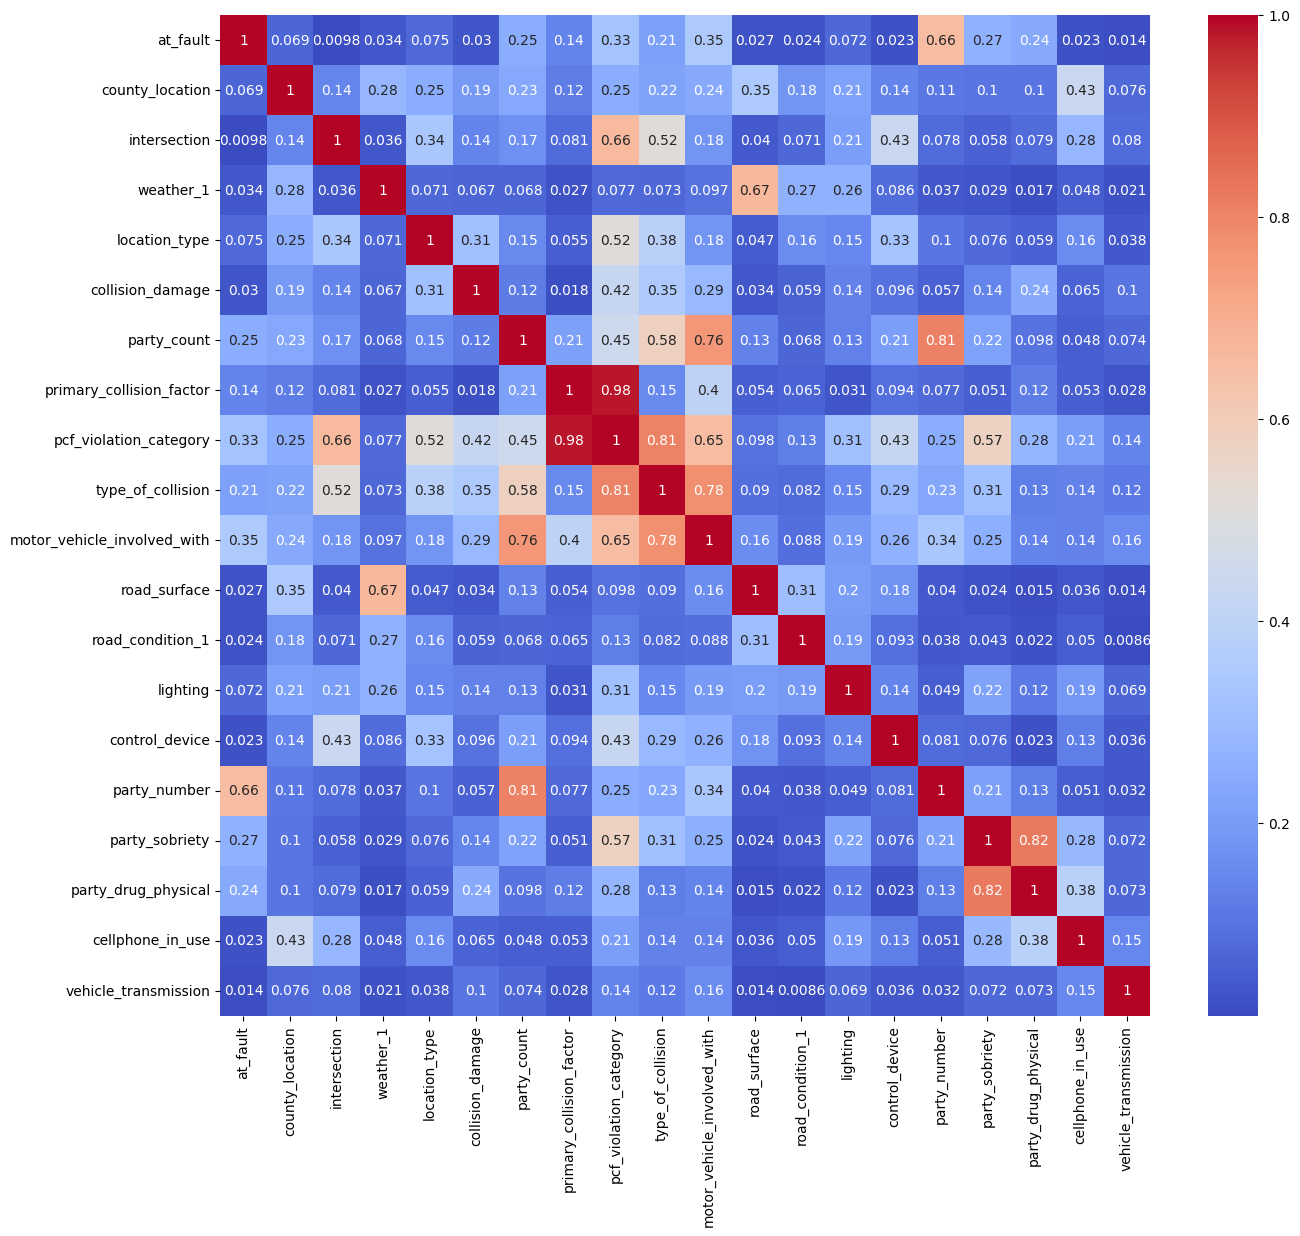

In [74]:
plt.figure(figsize=(15, 13))
sns.heatmap(phik_matrix(data[[
    'at_fault',
    'county_location',
    'intersection',
    'weather_1',
    'location_type',
    'collision_damage',
    'party_count',
    'primary_collision_factor',
    'pcf_violation_category',
    'type_of_collision',
    'motor_vehicle_involved_with',
    'road_surface',
    'road_condition_1',
    'lighting',
    'control_device',
    'party_number',
    'party_sobriety',
    'party_drug_physical',
    'cellphone_in_use',
    'vehicle_transmission',
]], interval_cols=['distance', 'insurance_premium', 'vehicle_age', 'collision_month', 'collision_day', 'collision_hour']), annot=True, cmap='coolwarm')
plt.show()

In [75]:
num_cols = [
    'distance', 
    'insurance_premium', 
    'vehicle_age', 
    'collision_month', 
    'collision_day', 
    'collision_hour'
]
cat_cols = [
    'county_location',
    'intersection',
    'weather_1',
    'location_type',
    'collision_damage',
    'party_count',
    'primary_collision_factor',
    'pcf_violation_category',
    'type_of_collision',
    'motor_vehicle_involved_with',
    'road_surface',
    'road_condition_1',
    'lighting',
    'control_device',
    'party_number',
    'party_sobriety',
    'party_drug_physical',
    'cellphone_in_use',
    'vehicle_transmission'
]
all_cols = num_cols + cat_cols

In [76]:
X = data[all_cols]
y = data.at_fault

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    shuffle=True,
    stratify=y)

In [77]:
def data_preporation(
        numeric_cols: List[str] = num_cols,
        category_cols: List[str] = cat_cols,
        X_train: pd.DataFrame = X_train,
        X_test: pd.DataFrame = X_test
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    
    preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numeric_cols),
        ('cat', OrdinalEncoder(
            handle_unknown='use_encoded_value', 
            unknown_value=np.nan                     
        ), category_cols)
    ], remainder='passthrough')

    X_train_processed = preprocessor.fit_transform(X_train)
    X_test_processed = preprocessor.transform(X_test)

    feature_names = preprocessor.get_feature_names_out()
    X_train = pd.DataFrame(X_train_processed, columns=feature_names)
    X_test = pd.DataFrame(X_test_processed, columns=feature_names)
    return X_train, X_test

X_train, X_test = data_preporation()

## Шаг 5. Найдите лучшую модель

In [ ]:
class BaseModel(ABC):
    def __init__(self, X_train, y_train, X_test, y_test):
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.model = None
        self.best_params = None
    
    @abstractmethod
    def create_model(self, params):
        pass
    
    @abstractmethod
    def objective(self, trial):
        pass
    
    def optimize(self, n_trials=100):
        study = optuna.create_study(direction='maximize')
        study.optimize(self.objective, n_trials=n_trials)
        self.best_params = study.best_params
        return study.best_params
    
    @abstractmethod
    def train(self, params=None):
        pass
    
    @abstractmethod
    def _calculate_f1(self):
        pass

In [79]:
class NeuralNetworkModel(BaseModel):
    def __init__(self, X_train, y_train, X_test, y_test, device=device):
        super().__init__(X_train, y_train, X_test, y_test)
        self.device = device
        self._prepare_data()
    # подготовка данных и архитектура нейронной сети
    def _prepare_data(self):
        self.X_train_torch = torch.FloatTensor(self.X_train.values).to(self.device)
        self.y_train_torch = torch.FloatTensor(self.y_train.values).to(self.device)
        self.X_test_torch = torch.FloatTensor(self.X_test.values).to(self.device)
        self.y_test_torch = torch.FloatTensor(self.y_test.values).to(self.device)
        self.train_dataset = TensorDataset(self.X_train_torch, self.y_train_torch)
    
    def create_model(self, params):
        class Net(nn.Module):
            def __init__(self, input_size, hidden_units, dropout_rate):
                super().__init__()
                self.layers = nn.Sequential(
                    nn.Linear(input_size, hidden_units),
                    nn.BatchNorm1d(hidden_units),
                    nn.ReLU(),
                    nn.Dropout(dropout_rate),
                    nn.Linear(hidden_units, hidden_units//2),
                    nn.BatchNorm1d(hidden_units//2),
                    nn.ReLU(),
                    nn.Dropout(dropout_rate),
                    nn.Linear(hidden_units//2, hidden_units//4),
                    nn.BatchNorm1d(hidden_units//4),
                    nn.ReLU(),
                    nn.Dropout(dropout_rate),
                    nn.Linear(hidden_units//4, hidden_units//8),
                    nn.BatchNorm1d(hidden_units//8),
                    nn.ReLU(),
                    nn.Dropout(dropout_rate),
                    nn.Linear(hidden_units//8, 1),
                    #nn.Sigmoid() #сигмоида не испольузется потому что выбрана BCEWithLogitsLoss в функции потерь
                )
                
            
            def forward(self, x):
                return self.layers(x)
        
        return Net(
            input_size=self.X_train.shape[1],
            hidden_units=params['hidden_units'],
            dropout_rate=params['dropout_rate']
        ).to(self.device)
    
    # подбор гиперпараметров с оптуной
    def objective(self, trial):
        params = {
            'hidden_units': trial.suggest_categorical('hidden_units', [32, 64, 128, 256, 512, 1024, 2048]),
            'dropout_rate': trial.suggest_float('dropout_rate', 0.1, 0.5),
            'lr': trial.suggest_float('lr', 1e-5, 1e-1, log=True),
            'batch_size': trial.suggest_categorical('batch_size', [32, 64, 128, 256, 512, 1024, 2048])
        }
        
        print(f"\n=== starting neural network trial {trial.number} ===")
        print(f"parameters: {params}")

        train_loader = DataLoader(self.train_dataset, batch_size=params['batch_size'], shuffle=True)
        net = self.create_model(params)
        optimizer = torch.optim.AdamW(net.parameters(), lr=params['lr'])
        loss_fn = nn.BCEWithLogitsLoss()
        
        best_f1 = 0
        patience = 20
        no_improve = 0
        num_epoch = 1

        for epoch in range(num_epoch):
            net.train()
            for inputs, labels in train_loader:
                optimizer.zero_grad()
                train_preds = net(inputs)
                train_loss = loss_fn(train_preds, labels.unsqueeze(1)) 
                train_loss.backward()
                optimizer.step()
            
            if epoch % 5 == 0 or epoch == num_epoch -1:
                net.eval()
                with torch.no_grad():
                    outputs = net(self.X_test_torch)
                    test_preds = (outputs > 0.5).float()
                    test_f1 = sklearn_f1_score(self.y_test_torch.cpu(), test_preds.cpu())
                    
                    if test_f1 > best_f1:
                        best_f1 = test_f1
                        no_improve = 0
                        best_epoch = epoch
                    else:
                        no_improve += 1

                    print(f"Trial {trial.number} | Epoch {epoch:3d} | "
                          f"Val F1: {test_f1:.4f} | Best F1: {best_f1:.4f} @ Epoch {best_epoch}")

                    if no_improve >= patience:
                        print(f"Early stopping at epoch {epoch}")
                        break

                trial.report(test_f1, epoch)
                if trial.should_prune():
                    print(f"Pruned trial {trial.number} at epoch {epoch}")
                    raise optuna.exceptions.TrialPruned()
        
        print(f"=== Completed Trial {trial.number} | Best F1: {best_f1:.4f} ===")
        return best_f1
    
    def train(self, params=None):
        params = self.best_params
        
        self.model = self.create_model(params)
        optimizer = torch.optim.Adam(self.model.parameters(), lr=params['lr'])
        loss_fn = nn.BCEWithLogitsLoss()
        train_loader = DataLoader(self.train_dataset, batch_size=params['batch_size'], shuffle=True)

        for epoch in range(200):
            for inputs, labels in train_loader:
                optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = loss_fn(outputs, labels.unsqueeze(1))
                loss.backward()
                optimizer.step()
        
        return self.model
    
    def ret_test_preds(self):
        self.model.eval()
        with torch.no_grad():
            test_outputs = self.model(self.X_test_torch)
            predicted = (test_outputs > 0.5).float()
            return predicted
    
    def _calculate_f1(self):
        self.model.eval()
        with torch.no_grad():
            test_outputs = self.model(self.X_test_torch)
            predicted = (test_outputs > 0.5).float()
            return sklearn_f1_score(self.y_test_torch.cpu().numpy(), predicted.cpu().numpy(), average='binary')

In [80]:
class LightGBMModel(BaseModel):
    def create_model(self, params):
        params.update({
            'objective': 'binary',
            'metric': 'binary_logloss',
            'verbosity': -1,
            'n_jobs': -1
        })
        return lgb.LGBMClassifier(**params)
    
    def objective(self, trial):
        print(f"\n=== starting LightGBM trial {trial.number} ===")
        params = {
            'num_leaves': trial.suggest_int('num_leaves', 20, 300),
            'learning_rate': trial.suggest_float('learning_rate', 0.0001, 0.2, log=True),
            'max_depth': trial.suggest_int('max_depth', 3, 15),
            'min_child_samples': trial.suggest_int('min_child_samples', 10, 200),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
            'reg_alpha': trial.suggest_float('reg_alpha', 1e-9, 10.0, log=True),
            'reg_lambda': trial.suggest_float('reg_lambda', 1e-9, 10.0, log=True),
        }
        
        train_data = lgb.Dataset(self.X_train, label=self.y_train)
        test_data = lgb.Dataset(self.X_test, label=self.y_test, reference=train_data)

        model = lgb.train(
            {**params, 'objective': 'binary', 'metric': 'binary_logloss', 'verbosity': -1},
            train_data,
            valid_sets=[test_data],
            num_boost_round=200,
            callbacks=[lgb.early_stopping(100), lgb.log_evaluation(100)]
        )

        preds = model.predict(self.X_test)
        preds_binary = np.where(preds > 0.5, 1, 0)
        f1 = sklearn_f1_score(self.y_test, preds_binary)

        print(f"\nTrial {trial.number} finished | Best F1: {f1:.4f}")
        return f1
    
    def train(self, params=None):
        params = self.best_params
        
        train_data = lgb.Dataset(self.X_train, label=self.y_train)
        test_data = lgb.Dataset(self.X_test, label=self.y_test, reference=train_data)
        
        self.model = lgb.train(
            {**params, 'objective': 'binary', 'metric': 'binary_logloss', 'verbosity': -1},
            train_data,
            valid_sets=[test_data],
            num_boost_round=1000,
            callbacks=[lgb.early_stopping(200), lgb.log_evaluation(50)]
        )
        
        return self.model
    
    def ret_test_preds(self):
        test_preds = self.model.predict(self.X_test)
        test_preds_binary = np.where(test_preds > 0.5, 1, 0)
        return test_preds_binary
    
    def _calculate_f1(self):
        test_preds = self.model.predict(self.X_test)
        test_preds_binary = np.where(test_preds > 0.5, 1, 0)
        return sklearn_f1_score(self.y_test, test_preds_binary)

In [81]:
class RandomForestModel(BaseModel):
    def create_model(self, params):
        return RandomForestClassifier(
            **params,
            random_state=42,
            n_jobs=-1
        )
    
    def objective(self, trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 500),
            'max_depth': trial.suggest_int('max_depth', 3, 15),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
            'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
            'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
            'class_weight': trial.suggest_categorical('class_weight', [None, 'balanced', 'balanced_subsample'])
        }
        
        scores = cross_val_score(
            self.create_model(params),
            self.X_train,
            self.y_train,
            cv=3,
            scoring='f1_macro',
            n_jobs=-1
        )
        
        f1 = scores.mean()
        return f1
    
    def train(self, params=None):
        params = self.best_params
        
        self.model = self.create_model(params).fit(self.X_train, self.y_train)
        return self.model
    
    def ret_test_preds(self):
        return self.model.predict(self.X_test)
    
    def _calculate_f1(self):
        test_preds = self.model.predict(self.X_test)
        return sklearn_f1_score(self.y_test, test_preds, average='macro')

In [83]:
models = {
    'LightGBM': LightGBMModel(X_train, y_train, X_test, y_test),
    'RandomForest': RandomForestModel(X_train, y_train, X_test, y_test),
    'NeuralNetwork': NeuralNetworkModel(X_train, y_train, X_test, y_test)
}

results = {}
for name, model in models.items():
    print(f"\n=== Optimizing {name} ===")
    best_params = model.optimize(n_trials=2)
    model.train()
    f1_score = model._calculate_f1()
    if model == 'NeuralNetwork':
        y_pred = model.ret_test_preds().cpu().numpy()
    else:
        y_pred = model.ret_test_preds()
    results[name] = {
        'f1_score': f1_score,
        'best_params': best_params,
        'model': model.model,
        'y_pred': y_pred
    }
    print(f"{name} F1 Score: {f1_score:.4f}")

print("\n=== Final Results ===")
for name, result in results.items():
    print(f"{name}: F1 = {result['f1_score']:.4f}")

[I 2025-04-05 18:51:11,782] A new study created in memory with name: no-name-522a7daf-ed67-4d7d-b136-18e321fb53a7



=== Optimizing LightGBM ===

=== starting LightGBM trial 0 ===
Training until validation scores don't improve for 100 rounds


[I 2025-04-05 18:51:12,175] Trial 0 finished with value: 0.9184743398585926 and parameters: {'num_leaves': 75, 'learning_rate': 0.0530523010719159, 'max_depth': 7, 'min_child_samples': 174, 'subsample': 0.6185480781562119, 'colsample_bytree': 0.9652775037111831, 'reg_alpha': 0.055180901085287115, 'reg_lambda': 5.068993439335519e-05}. Best is trial 0 with value: 0.9184743398585926.


[100]	valid_0's binary_logloss: 0.238846
[200]	valid_0's binary_logloss: 0.232738
Did not meet early stopping. Best iteration is:
[200]	valid_0's binary_logloss: 0.232738

Trial 0 finished | Best F1: 0.9185

=== starting LightGBM trial 1 ===
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.644378


[I 2025-04-05 18:51:12,616] Trial 1 finished with value: 0.9139842199525631 and parameters: {'num_leaves': 179, 'learning_rate': 0.0007448410245858871, 'max_depth': 7, 'min_child_samples': 88, 'subsample': 0.662908022664424, 'colsample_bytree': 0.9447591910823245, 'reg_alpha': 6.218282166844739e-06, 'reg_lambda': 7.063391960275676e-06}. Best is trial 0 with value: 0.9184743398585926.


[200]	valid_0's binary_logloss: 0.60164
Did not meet early stopping. Best iteration is:
[200]	valid_0's binary_logloss: 0.60164

Trial 1 finished | Best F1: 0.9140
Training until validation scores don't improve for 200 rounds
[50]	valid_0's binary_logloss: 0.259159
[100]	valid_0's binary_logloss: 0.238846
[150]	valid_0's binary_logloss: 0.234276
[200]	valid_0's binary_logloss: 0.232738
[250]	valid_0's binary_logloss: 0.231903
[300]	valid_0's binary_logloss: 0.231549
[350]	valid_0's binary_logloss: 0.23111
[400]	valid_0's binary_logloss: 0.230487
[450]	valid_0's binary_logloss: 0.230118
[500]	valid_0's binary_logloss: 0.229721
[550]	valid_0's binary_logloss: 0.229173
[600]	valid_0's binary_logloss: 0.228912
[650]	valid_0's binary_logloss: 0.228894
[700]	valid_0's binary_logloss: 0.228719
[750]	valid_0's binary_logloss: 0.228472
[800]	valid_0's binary_logloss: 0.228155
[850]	valid_0's binary_logloss: 0.228075
[900]	valid_0's binary_logloss: 0.227609
[950]	valid_0's binary_logloss: 0.2270

[I 2025-04-05 18:51:14,429] A new study created in memory with name: no-name-2ae31840-e691-4ec5-9ecc-87e89d6c2b93


LightGBM F1 Score: 0.9197

=== Optimizing RandomForest ===


[I 2025-04-05 18:51:21,587] Trial 0 finished with value: 0.912588866927733 and parameters: {'n_estimators': 444, 'max_depth': 10, 'min_samples_split': 20, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'bootstrap': False, 'class_weight': 'balanced_subsample'}. Best is trial 0 with value: 0.912588866927733.
[I 2025-04-05 18:51:22,900] Trial 1 finished with value: 0.8871132349287526 and parameters: {'n_estimators': 151, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 9, 'max_features': 'log2', 'bootstrap': True, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.912588866927733.
[I 2025-04-05 18:51:26,124] A new study created in memory with name: no-name-3740cd79-6f9d-4b10-b550-f5624fb8e2bf


RandomForest F1 Score: 0.9167

=== Optimizing NeuralNetwork ===

=== starting neural network trial 0 ===
parameters: {'hidden_units': 64, 'dropout_rate': 0.42934002239336155, 'lr': 5.755446866101796e-05, 'batch_size': 512}


[I 2025-04-05 18:51:26,696] Trial 0 finished with value: 0.00039085401602501464 and parameters: {'hidden_units': 64, 'dropout_rate': 0.42934002239336155, 'lr': 5.755446866101796e-05, 'batch_size': 512}. Best is trial 0 with value: 0.00039085401602501464.


Trial 0 | Epoch   0 | Val F1: 0.0004 | Best F1: 0.0004 @ Epoch 0
=== Completed Trial 0 | Best F1: 0.0004 ===

=== starting neural network trial 1 ===
parameters: {'hidden_units': 1024, 'dropout_rate': 0.12070461257869157, 'lr': 0.00011481257315717584, 'batch_size': 128}


[I 2025-04-05 18:51:28,015] Trial 1 finished with value: 0.8883950617283951 and parameters: {'hidden_units': 1024, 'dropout_rate': 0.12070461257869157, 'lr': 0.00011481257315717584, 'batch_size': 128}. Best is trial 1 with value: 0.8883950617283951.


Trial 1 | Epoch   0 | Val F1: 0.8884 | Best F1: 0.8884 @ Epoch 0
=== Completed Trial 1 | Best F1: 0.8884 ===
NeuralNetwork F1 Score: 0.9110

=== Final Results ===
LightGBM: F1 = 0.9197
RandomForest: F1 = 0.9167
NeuralNetwork: F1 = 0.9110


### Шаг 6. Проверка лучшей модели

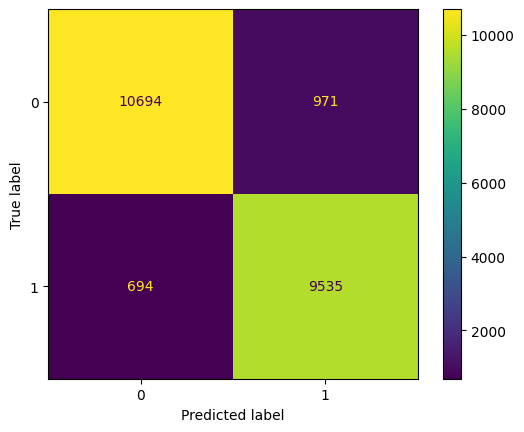

In [85]:
y_pred = results['LightGBM']['y_pred']
cm_rfc = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_rfc)
disp.plot();

In [86]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.92      0.93     11665
           1       0.91      0.93      0.92     10229

    accuracy                           0.92     21894
   macro avg       0.92      0.92      0.92     21894
weighted avg       0.92      0.92      0.92     21894



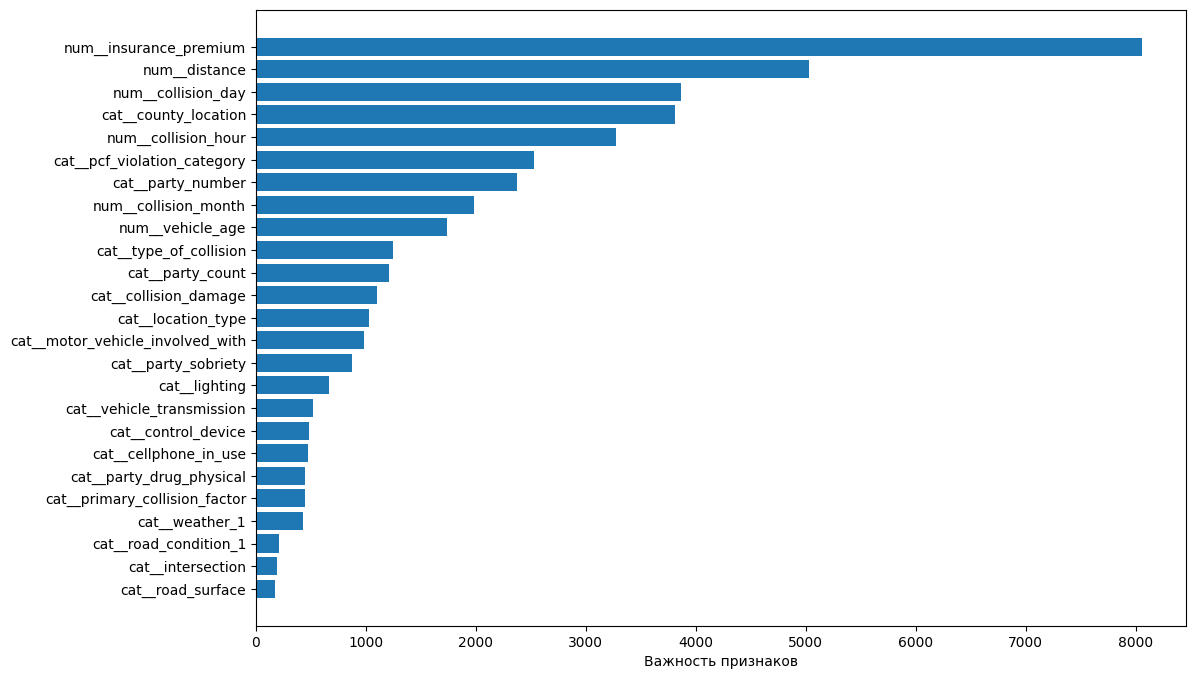

In [87]:
importance_type = 'split'
feature_importance = pd.DataFrame({
    'feature': results['LightGBM']['model'].feature_name(),
    'importance': results['LightGBM']['model'].feature_importance(importance_type=importance_type)
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 8))
plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.xlabel('Важность признаков')
plt.gca().invert_yaxis()
plt.show()

In [92]:
print(data['at_fault'].corr(data['insurance_premium']).round(3))

-0.145


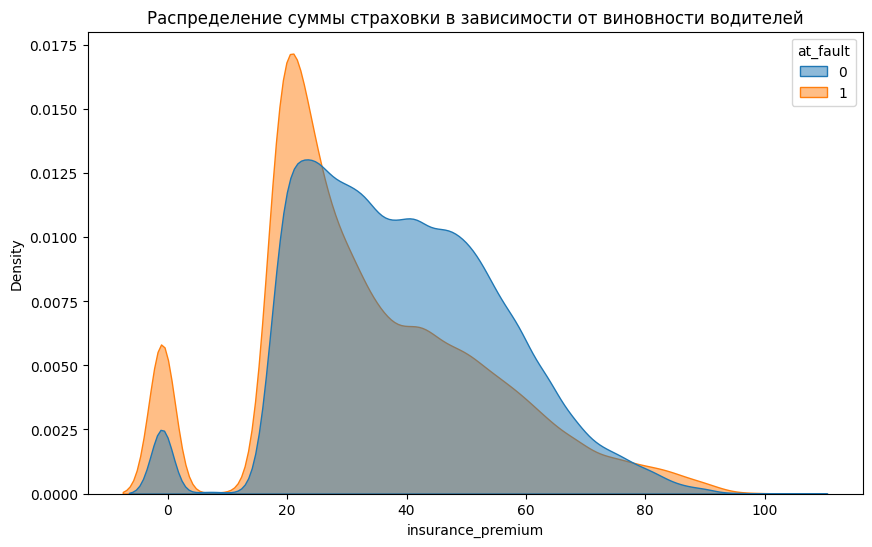

In [93]:
plt.figure(figsize=(10, 6))
sns.kdeplot(data=data, x='insurance_premium', hue='at_fault', fill=True, alpha=0.5)
plt.title('Распределение суммы страховки в зависимости от виновности водителей')
plt.show()

### Шаг 7. Общий вывод по модели